In [216]:
import scipy.io as spio
import numpy as np
import pandas as pd
import networkx as nx
import cdt.causality.graph.PC as PC
import sklearn
from pgmpy.models import MarkovModel, BayesianModel
from pgmpy.inference import VariableElimination
from cdt.independence.graph.Lasso import Glasso
from matplotlib import pyplot as plt

In [217]:
mat = spio.loadmat('rijksgt.mat')
data = mat['gt'][0][0]

In [218]:
gt = {
    'Cnames' : 0,
    'C'      : 1,
    'Ccount' : 2,
    'Cnote'  : 3,
    'Y'      : 4,
    'Yinx'   : 5,
    'Yhist'  : 6,
    'T'      : 7,
    'Tsum'   : 8,
    'Thist'  : 9,
    'Thist2' : 10,
    'Tnames' : 11,
    'Tnote'  : 12,
    'M'      : 13,
    'Msum'   : 14,
    'Mhist'  : 15,
    'Mhist2' : 16,
    'Mnames' : 17,
    'N'      : 18,
    'det'    : 19,
    'set'    : 20
}

In [219]:
Ymsk = [abs(year[1]-year[0]) < 100 for year in data[gt['Y']]]

C = data[gt['C']][Ymsk]
C = [ar[0] for ar in C]
T = np.where(data[gt['T']][Ymsk] != 0, 1, 0)
M = np.where(data[gt['M']][Ymsk] != 0, 1, 0)
Y = np.mean(data[gt['Y']][Ymsk], axis=1)
N = len(C)

In [220]:
Tnum = 10
Mnum = 10

Tsums = np.sum(T, axis=0)
Tinds = np.argsort(Tsums, axis=0)[-Tnum:]

Msums = np.sum(M, axis=0)
Minds = np.argsort(Msums, axis=0)[-Mnum:]

T = [ar[Tinds] for ar in T]
M = [ar[Minds] for ar in M]

Tlabels = ['T'+str(i) for i in range(Tnum)]
Mlabels = ['M'+str(i) for i in range(Mnum)]

Tdf = pd.DataFrame(T, columns=Tlabels)
Mdf = pd.DataFrame(M, columns=Mlabels)

In [221]:
df = pd.DataFrame({'C': C, 'Y': Y}).join(Tdf).join(Mdf)
dfs = df.sample(frac=1)

In [222]:
learn_train = int(0.4*N)
learn_val = int(0.5*N)
inference_train = int(0.9*N)
inference_test = N - learn_train - learn_val - inference_train

In [223]:
alphas = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999]
bics = []

for alpha in alphas:
    cov = sklearn.covariance.GraphicalLasso(alpha=alpha).fit(dfs.iloc[:learn_train])
    adj = np.where(abs(cov.precision_) < 1e-10, 0, 1)
    np.fill_diagonal(adj, 0)
    dim = np.sum(adj)
    
    bic = np.log(learn_val) * dim - 2*cov.score(dfs.iloc[learn_train:learn_train + learn_val])
    bics.append(bic)
    
min_alpha = alphas[np.argmin(bics)]

cov = sklearn.covariance.GraphicalLasso(alpha=min_alpha).fit(dfs.iloc[:learn_train])
adj = np.where(abs(cov.precision_) < 1e-10, 0, 1)
np.fill_diagonal(adj, 0)
G = nx.from_numpy_matrix(adj)

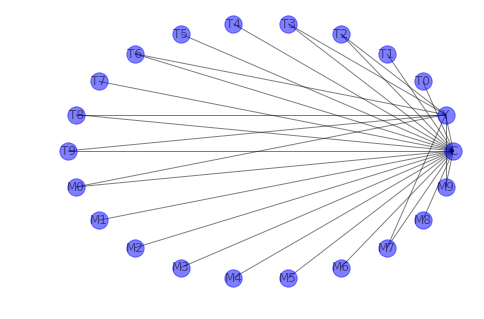

In [225]:
labels = list(dfs.columns)
mapping = {i : labels[i] for i in range(len(labels))}
G = nx.relabel_nodes(G, mapping)

f = plt.figure()
nx.draw_circular(G, with_labels = True, node_color='b', alpha=0.5)
f.savefig('ugm.png')

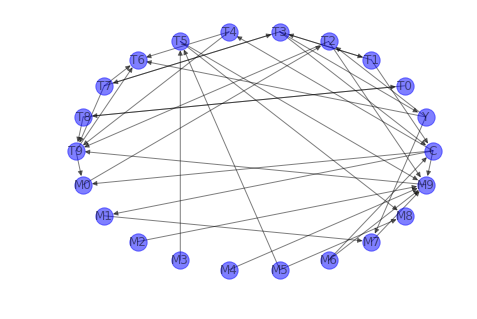

In [233]:
pc = PC(CItest='gaussian', method_indep='corr', alpha=0.00000000001, verbose=None)
dag = pc.create_graph_from_data(dfs.iloc[:learn_train])
f = plt.figure()
nx.draw_circular(dag, with_labels = True, node_color='b', alpha=0.5)
f.savefig('dag.png')

In [141]:
mm = MarkovModel()
mm.add_nodes_from(G)
mm.add_edges_from(G.edges)

In [185]:
bm_edges = [(edge[1], edge[0]) for edge in G.edges]
bm_edges[0] = (bm_edges[0][1], bm_edges[0][0])
bm = BayesianModel()
bm.add_nodes_from(G)
bm.add_edges_from(bm_edges)

In [190]:
#bm = mm.to_bayesian_model()
start = time.time()
bm.fit(dfs.iloc[learn_val:inference_train])
end = time.time()
print(end-start)

41260.29506993294


In [ ]:
inference = VariableElimination(bm)

In [131]:
query = inference.map_query(['Y'], evidence={'T2': 1, 'T3' : 0})

Eliminating: T1: 100%|██████████| 8/8 [00:00<00:00, 210.32it/s]


In [132]:
test = df.iloc[-10:]
preds = []

for ix, row in test.iterrows():
    evidence = row.drop('Y').to_dict()
    pred = inference.map_query(['Y'], evidence=evidence)
    preds.append(pred)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [133]:
preds

[{'Y': 1755.0},
 {'Y': 1755.0},
 {'Y': 1755.0},
 {'Y': 1755.0},
 {'Y': 1755.0},
 {'Y': 1755.0},
 {'Y': 1753.0},
 {'Y': 0.0},
 {'Y': 0.0},
 {'Y': 0.0}]

In [165]:
nb = MultinomialNB()

X = dfs.iloc[inference_train:].drop('Y', 1)
y = dfs.iloc[inference_train:]['Y'].values

In [167]:
y = np.asarray(y,dtype=np.float64)
nb.fit(X, y)

ValueError: Unknown label type: (array([1772. , 1584. , 1649.5, ..., 1589.5, 1537.5, 1686. ]),)